# **Başlıktan Kategori Tahmini (Gözetimli Öğrenme - ML)**

***1.  Veri Seti Hazırlığı*** 

In [1]:
print("Gerekli kütüphaneler yükleniyor...")

!pip install datasets matplotlib seaborn scikit-learn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
import re # Metin temizliği için gerekli
import warnings


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier # Alternatif model
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, ConfusionMatrixDisplay

warnings.filterwarnings("ignore")
print("Kütüphaneler başarıyla import edildi.")

# Çalışacağımız kategorileri ve örnek sayısını belirledik

category_list_hf = [
    "raw_review_Books",
    "raw_review_Electronics",
    "raw_review_Grocery_and_Gourmet_Food",
    "raw_review_Home_and_Kitchen",
    "raw_review_Sports_and_Outdoors"
]

category_list_clean = [name.replace("raw_review_", "") for name in category_list_hf]

num_samples_per_category = 3000 

list_of_dfs = []
print("\nVeri setleri Hugging Face üzerinden 'streaming' modunda indiriliyor...")

for category_name_hf in category_list_hf:
    print(f"-> '{category_name_hf}' kategorisi işleniyor...")

    ds = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        name=category_name_hf,
        split='full', 
        streaming=True, 
        trust_remote_code=True
    )

    stream_sample = ds.take(num_samples_per_category)

    df_temp = pd.DataFrame(list(stream_sample))

    df_temp['category'] = category_name_hf.replace("raw_review_", "")
    list_of_dfs.append(df_temp)

full_df = pd.concat(list_of_dfs, ignore_index=True)


# yorum başlığı ('title') ve yorum metnini ('text') birleştiriyoruz.
# NaN (boş) değerler hataya sebep olmasın diye önce onları temizliyoruz.
full_df['title'] = full_df['title'].fillna('')

# 'text_input' adında yeni bir sütun oluşturarak modelimizin girdisini hazırlıyoruz.
full_df['text_input'] = full_df['title'] + ' ' + full_df['text']

# Sadece ihtiyacımız olan sütunları seçip veriyi karıştıralım
# Veriyi karıştırıyoruz (shuffle), bu sayede modelin verinin sırasına göre 
df = full_df[['text_input', 'category']].copy()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nVeri Yükleme Tamamlandı!")
print(f"Toplam Satır Sayısı: {len(df)}")
print("-" * 50)


Gerekli kütüphaneler yükleniyor...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 7.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cufft-cu12==11.2.1.3; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cufft-cu12 11.4.0.6 which is 

README.md: 0.00B [00:00, ?B/s]

Amazon-Reviews-2023.py: 0.00B [00:00, ?B/s]

-> 'raw_review_Electronics' kategorisi işleniyor...
-> 'raw_review_Grocery_and_Gourmet_Food' kategorisi işleniyor...
-> 'raw_review_Home_and_Kitchen' kategorisi işleniyor...
-> 'raw_review_Sports_and_Outdoors' kategorisi işleniyor...

Veri Yükleme Tamamlandı!
Toplam Satır Sayısı: 15000
--------------------------------------------------


***2. Geliştirilmiş Keşifsel Veri Analizi (EDA)***


--- Geliştirilmiş Keşifsel Veri Analizi (EDA) ---

Veri Setinin İlk 5 Satırı:


,text_input,category
0,"works well, but is VERY sharp edged. I actuall...",Home_and_Kitchen
1,Don’t buy when temperatures are high All choco...,Grocery_and_Gourmet_Food
2,Great addition to any survival kit or camping ...,Sports_and_Outdoors
3,One of my favorite books of 2014! This second ...,Books
4,This Alarm clock is our main use for this cloc...,Electronics



Veri Seti Hakkında Bilgi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text_input  15000 non-null  object
 1   category    15000 non-null  object
dtypes: object(2)
memory usage: 234.5+ KB


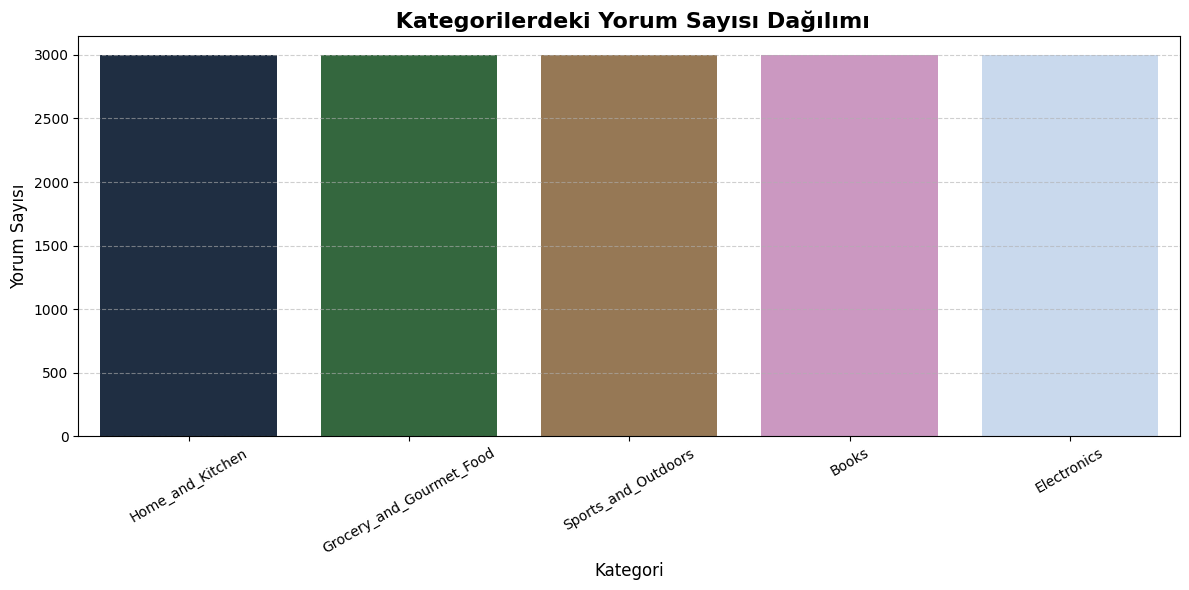

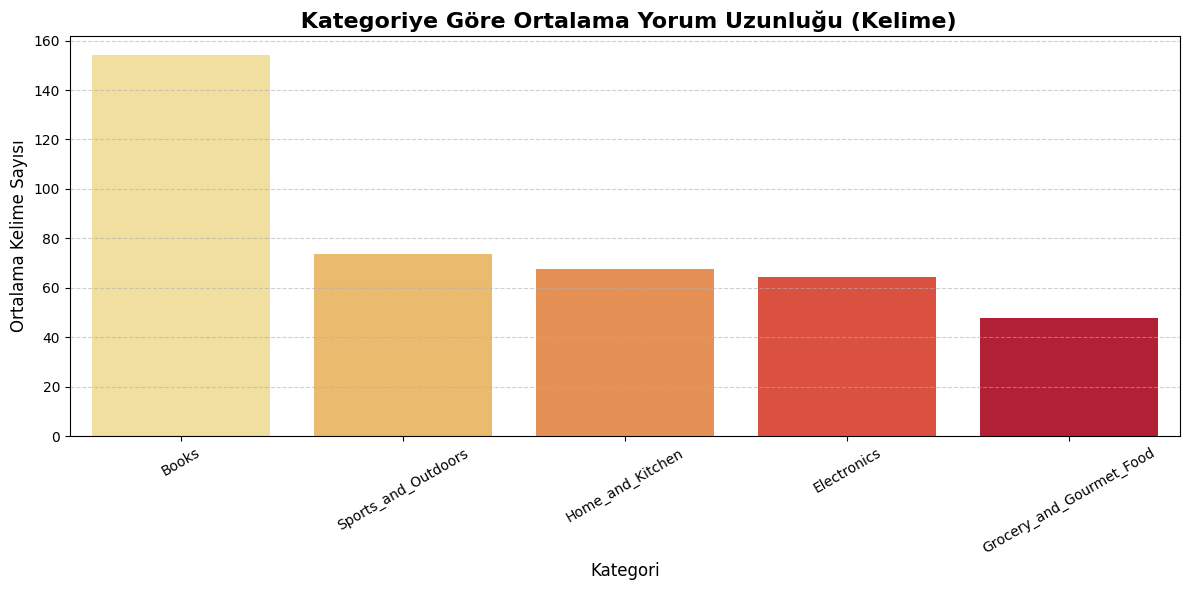

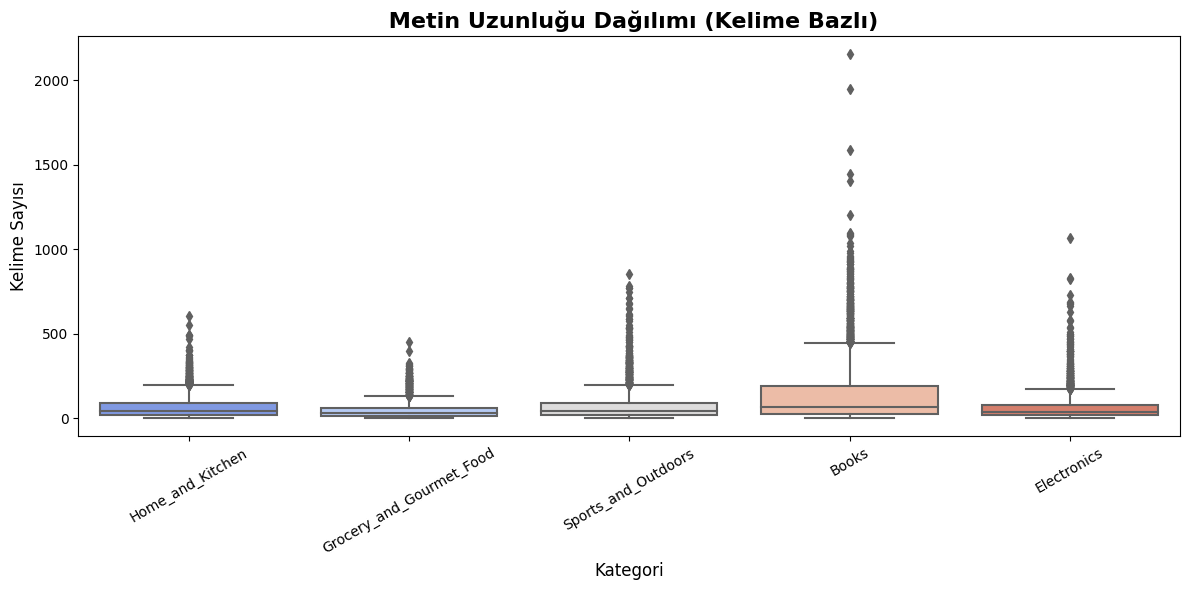

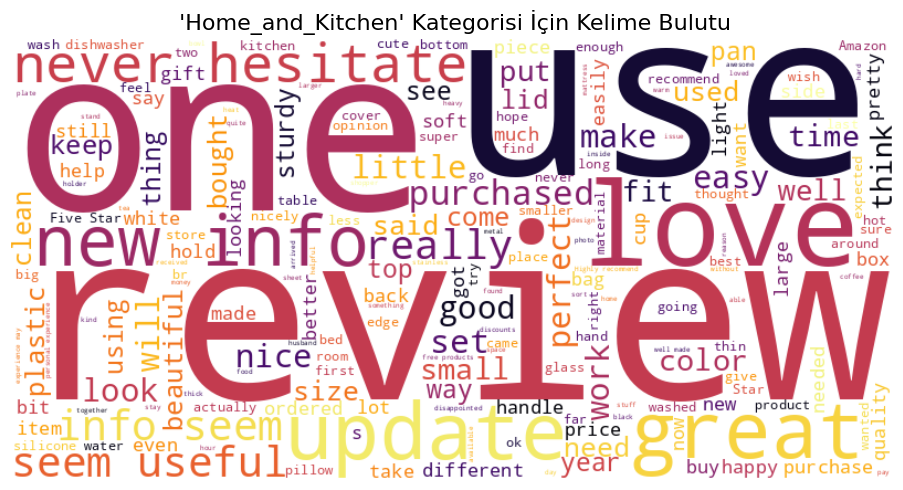

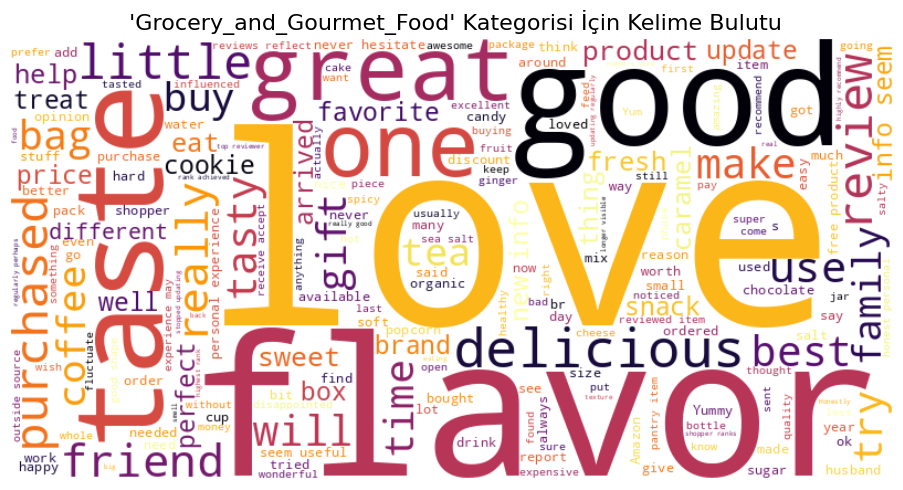


 Geliştirilmiş EDA başarıyla tamamlandı.
------------------------------------------------------------


In [2]:
print("\n--- Geliştirilmiş Keşifsel Veri Analizi (EDA) ---")

# 1. Temel İncelemeler
print("\nVeri Setinin İlk 5 Satırı:")
display(df.head())

print("\nVeri Seti Hakkında Bilgi:")
df.info()

# 2. Kategori Sayımları
category_counts = df['category'].value_counts()

# 3. Görselleştirmeler
import matplotlib.ticker as mtick

plt.figure(figsize=(12, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette="cubehelix")
plt.title(' Kategorilerdeki Yorum Sayısı Dağılımı', fontsize=16, weight='bold')
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Yorum Sayısı', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 4. Metin Uzunluğu Analizi
df['text_length'] = df['text_input'].apply(lambda x: len(x.split()))

# Ortalama kelime sayısı
avg_length_words = df.groupby('category')['text_length'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_length_words.index, y=avg_length_words.values, palette="YlOrRd")
plt.title(' Kategoriye Göre Ortalama Yorum Uzunluğu (Kelime)', fontsize=16, weight='bold')
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Ortalama Kelime Sayısı', fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# 5. Kategoriye Göre Metin Uzunluk Dağılımı (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='category', y='text_length', palette="coolwarm")
plt.title(' Metin Uzunluğu Dağılımı (Kelime Bazlı)', fontsize=16, weight='bold')
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Kelime Sayısı', fontsize=12)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 6. Kelime Bulutu (wordcloud) – İlk 2 kategori için örnek
from wordcloud import WordCloud

for cat in df['category'].unique()[:2]:
    text = " ".join(df[df['category'] == cat]['text_input'].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='inferno').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f" '{cat}' Kategorisi İçin Kelime Bulutu", fontsize=16)
    plt.tight_layout()
    plt.show()

print("\n Geliştirilmiş EDA başarıyla tamamlandı.")
print("-" * 60)


***3. Veri Ön İşleme Ve Model Eğitimi***

> ***3.1 – LogisticRegression ile Model Eğitimi***


--- AŞAMA 1: LogisticRegression (3 Kategori) Başladı ---

Aşama 1 için seçilen kategoriler: ['Books', 'Electronics', 'Grocery_and_Gourmet_Food']
Kullanılacak veri boyutu: 9000 satır

Model eğitiliyor...
Model eğitimi tamamlandı.

Doğruluk (Accuracy): 0.9302
Ağırlıklı F1 Skoru: 0.9302

Sınıflandırma Raporu (Classification Report):
                          precision    recall  f1-score   support

                   Books       0.94      0.92      0.93       750
             Electronics       0.91      0.93      0.92       750
Grocery_and_Gourmet_Food       0.94      0.94      0.94       750

                accuracy                           0.93      2250
               macro avg       0.93      0.93      0.93      2250
            weighted avg       0.93      0.93      0.93      2250


Karmaşıklık Matrisi:


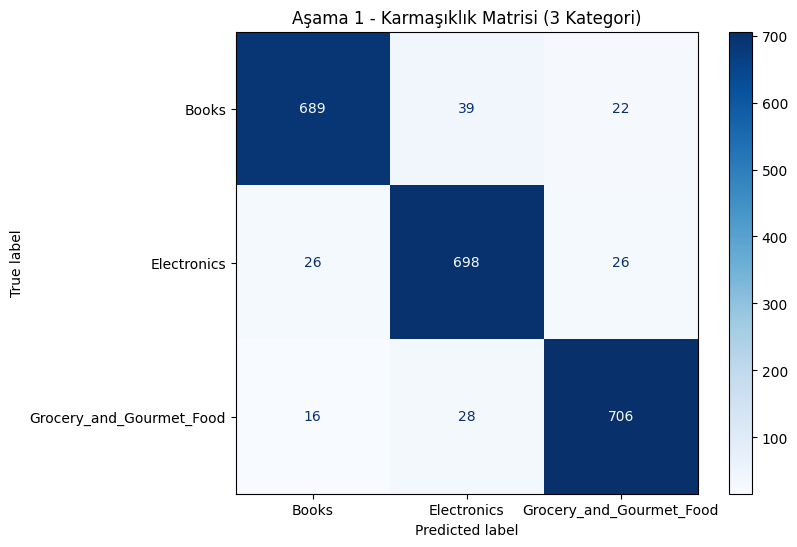


Normalleştirilmiş Karmaşıklık Matrisi:


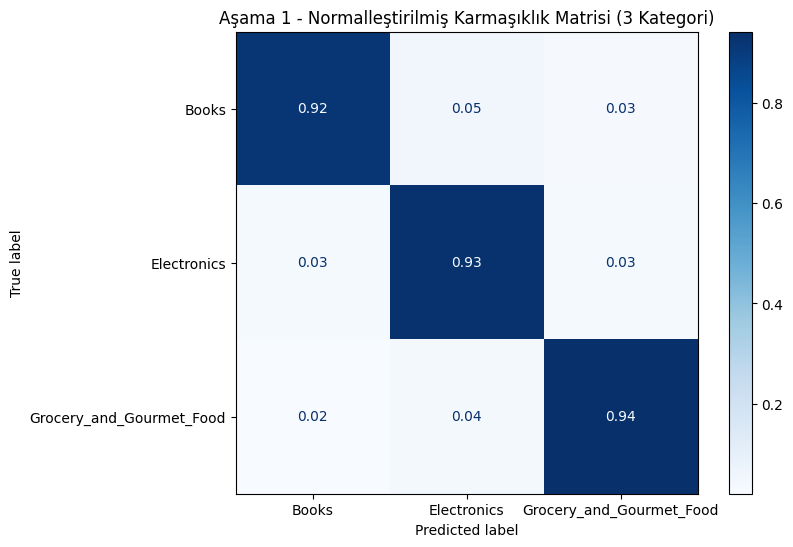


--- LogisticRegression (5 Kategori) Başladı ---

Aşama 2 için kullanılan kategoriler: ['Home_and_Kitchen', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Books', 'Electronics']
Kullanılacak veri boyutu: 15000 satır

Model 5 kategori ile yeniden eğitiliyor...
Model eğitimi tamamlandı.

Doğruluk (Accuracy): 0.8187
Ağırlıklı F1 Skoru: 0.8187

Sınıflandırma Raporu (Classification Report):
                          precision    recall  f1-score   support

                   Books       0.92      0.91      0.91       750
             Electronics       0.80      0.79      0.80       750
Grocery_and_Gourmet_Food       0.89      0.90      0.89       750
        Home_and_Kitchen       0.75      0.76      0.75       750
     Sports_and_Outdoors       0.74      0.73      0.73       750

                accuracy                           0.82      3750
               macro avg       0.82      0.82      0.82      3750
            weighted avg       0.82      0.82      0.82      3750


Karmaşık

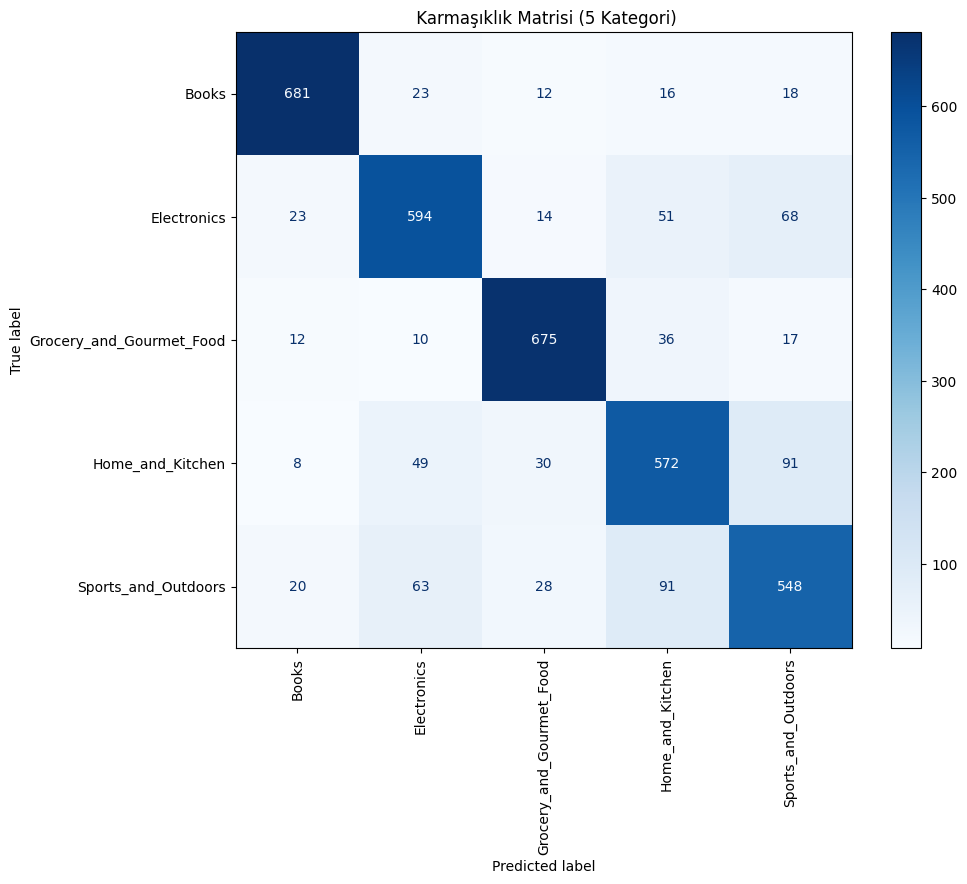

--------------------------------------------------

Normalleştirilmiş Karmaşıklık Matrisi:


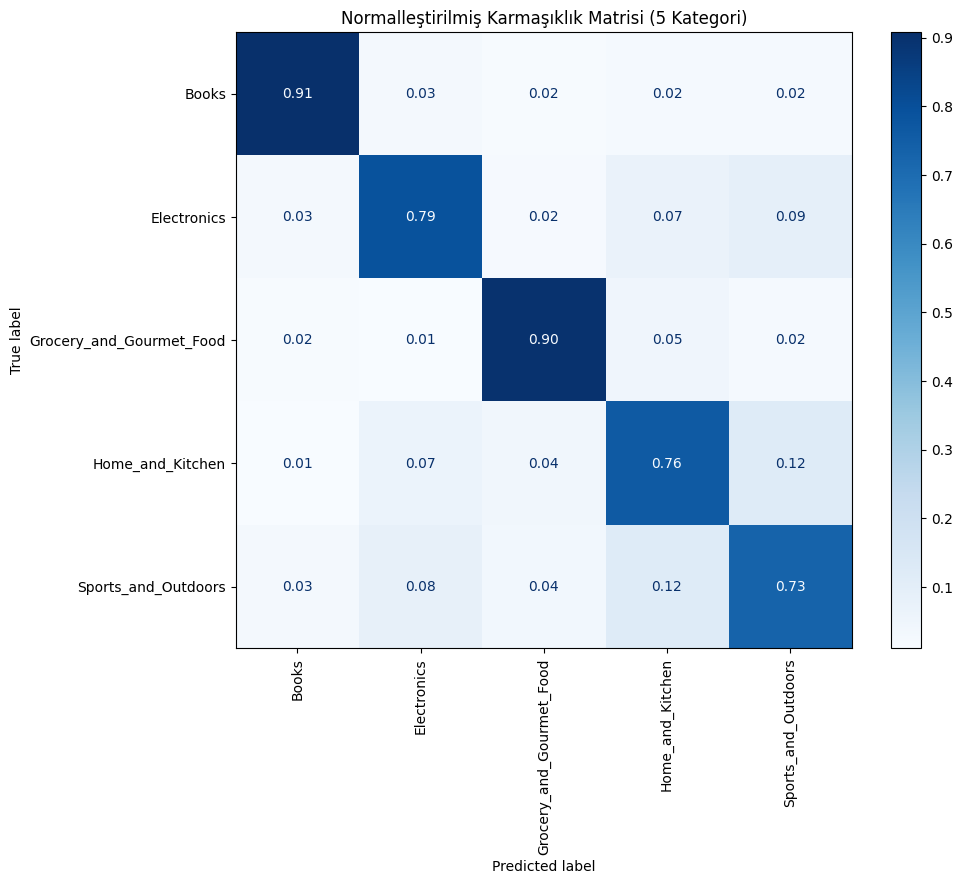

In [3]:
# LogisticRegression ile eğitim
# Metin verisini modelin anlayabileceği bir formata getirmek için ön işleme
def preprocess_text(text):
    """
    Bu fonksiyon bir metni alır ve aşağıdaki adımları uygular:
    1. Tüm harfleri küçük harfe çevirir.
    2. Noktalama işaretlerini kaldırır.
    3. Metindeki sayıları kaldırır.
    4. Fazla boşlukları tek boşluğa indirir.
    """
    text = str(text).lower() # Metin olmayan verileri de string'e çevir
    text = re.sub(r'[^\w\s]', '', text) # Alfanümerik olmayanları ve boşlukları koru
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text


print("\n--- AŞAMA 1: LogisticRegression (3 Kategori) Başladı ---")

# 1. Veri Hazırlığı: Birbirinden çok farklı 3 kategoriyi seçme
stage1_categories = ["Books", "Electronics", "Grocery_and_Gourmet_Food"]
df_stage1 = df[df['category'].isin(stage1_categories)].copy()

print(f"\nAşama 1 için seçilen kategoriler: {stage1_categories}")
print(f"Kullanılacak veri boyutu: {len(df_stage1)} satır")

# 2. Ön işleme fonksiyonunu uygulama
df_stage1['processed_text'] = df_stage1['text_input'].apply(preprocess_text)

# 3. Veriyi Eğitim ve Test Setlerine Ayırma
X = df_stage1['processed_text']
y = df_stage1['category']
# `stratify=y` parametresi, eğitim ve test setlerindeki kategori dağılımlarının
# orijinal veri setindekiyle aynı olmasını sağlar. Bu, dengeli bir test için önemlidir.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# 4. Model Pipeline'ı Oluşturma ve Eğitme
# Pipeline: TF-IDF (vektörleştirme) ve Logistic Regression (sınıflandırma)
# adımlarını birleştirir. Bu, kodu daha temiz hale getirir ve veri sızıntısını önler.
pipeline_lr = make_pipeline(
    TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2)),
    LogisticRegression(max_iter=1000, random_state=42)
)

print("\nModel eğitiliyor...")
pipeline_lr.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

# 5. Değerlendirme
y_pred = pipeline_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nDoğruluk (Accuracy): {accuracy:.4f}")
print(f"Ağırlıklı F1 Skoru: {f1:.4f}")

print("\nSınıflandırma Raporu (Classification Report):")
print(classification_report(y_test, y_pred))

# Karmaşıklık Matrisi (Confusion Matrix)
print("\nKarmaşıklık Matrisi:")
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(pipeline_lr, X_test, y_test, ax=ax, cmap='Blues')
plt.title('Aşama 1 - Karmaşıklık Matrisi (3 Kategori)')
plt.show()
# Karmaşıklık Matrisi (Confusion Matrix) - Normalize
print("\nNormalleştirilmiş Karmaşıklık Matrisi:")
fig, ax = plt.subplots(figsize=(8, 6))

# 'normalize' ve 'values_format' parametreleri eklendi
ConfusionMatrixDisplay.from_estimator(
    pipeline_lr, 
    X_test, 
    y_test, 
    ax=ax, 
    cmap='Blues',
    normalize='true',  # Satırlara göre normalleştirme
    values_format='.2f' # Değerleri 2 ondalık basamakla göster
)
plt.title('Aşama 1 - Normalleştirilmiş Karmaşıklık Matrisi (3 Kategori)')
plt.show()

##################################################################################
print("\n--- LogisticRegression (5 Kategori) Başladı ---")

# 1. Veri Hazırlığı: 5 kategorinin tamamını kullanma
df_stage2 = df.copy() # En başta yüklediğimiz tam veri setini kullanıyoruz
df_stage2['processed_text'] = df_stage2['text_input'].apply(preprocess_text)

print(f"\nAşama 2 için kullanılan kategoriler: {df_stage2['category'].unique().tolist()}")
print(f"Kullanılacak veri boyutu: {len(df_stage2)} satır")

# 2. Model Eğitimi (Aynı pipeline'ı yeni veriyle eğiteceğiz)
X = df_stage2['processed_text']
y = df_stage2['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print("\nModel 5 kategori ile yeniden eğitiliyor...")
pipeline_lr.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

# 3. Değerlendirme ve Analiz
y_pred = pipeline_lr.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nDoğruluk (Accuracy): {accuracy:.4f}")
print(f"Ağırlıklı F1 Skoru: {f1:.4f}")

print("\nSınıflandırma Raporu (Classification Report):")
print(classification_report(y_test, y_pred))

# Karmaşıklık Matrisi
print("\nKarmaşıklık Matrisi:")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(pipeline_lr, X_test, y_test, ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title(' Karmaşıklık Matrisi (5 Kategori)')
plt.show()

print("-" * 50)

# Karmaşıklık Matrisi - Normalize
print("\nNormalleştirilmiş Karmaşıklık Matrisi:")
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    pipeline_lr, 
    X_test, 
    y_test, 
    ax=ax, 
    cmap='Blues', 
    xticks_rotation='vertical',
    normalize='true',
    values_format='.2f'
)
plt.title('Normalleştirilmiş Karmaşıklık Matrisi (5 Kategori)')
plt.show()


> ***3.2 – RandomForestClassifier ile Model Eğitimi***


--- RandomForestClassifier (3 Kategori) Başladı ---

Aşama 1 için seçilen kategoriler: ['Books', 'Electronics', 'Grocery_and_Gourmet_Food']
Kullanılacak veri boyutu: 9000 satır

RandomForest modeli 3 kategori ile eğitiliyor...
Model eğitimi tamamlandı.

--- Değerlendirme Sonuçları (3 Kategori) ---
                          precision    recall  f1-score   support

                   Books       0.99      0.82      0.89       750
             Electronics       0.78      0.94      0.86       750
Grocery_and_Gourmet_Food       0.92      0.89      0.90       750

                accuracy                           0.88      2250
               macro avg       0.90      0.88      0.88      2250
            weighted avg       0.90      0.88      0.88      2250



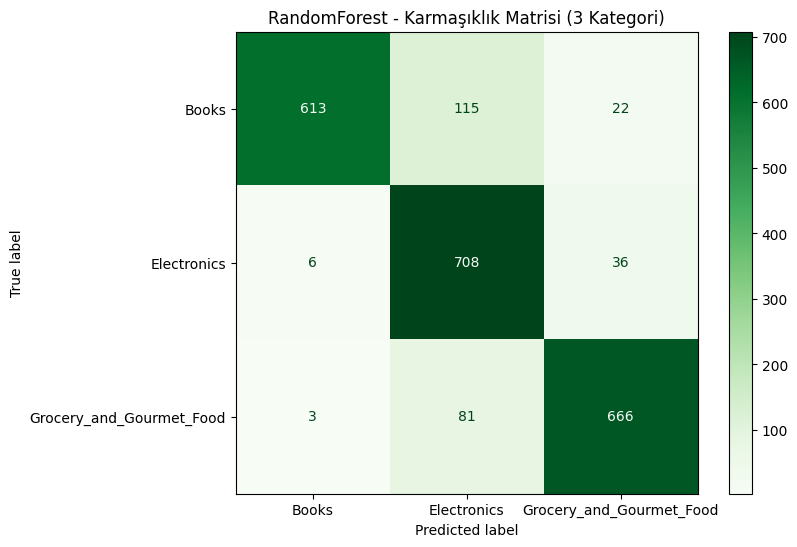

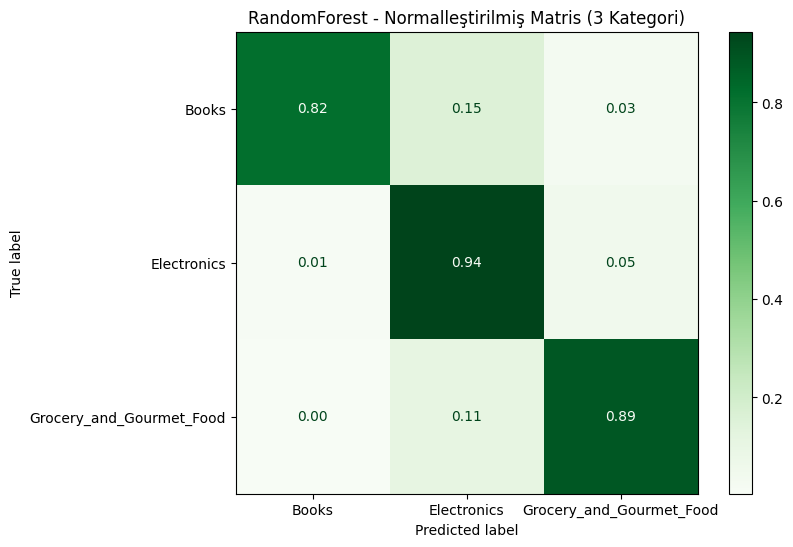


--- RandomForestClassifier (5 Kategori) Başladı ---

Aşama 2 için kullanılan kategoriler: ['Home_and_Kitchen', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Books', 'Electronics']
Kullanılacak veri boyutu: 15000 satır

RandomForest modeli 5 kategori ile yeniden eğitiliyor...
Model eğitimi tamamlandı.

--- Değerlendirme Sonuçları (5 Kategori) ---
                          precision    recall  f1-score   support

                   Books       0.93      0.83      0.87       750
             Electronics       0.81      0.62      0.70       750
Grocery_and_Gourmet_Food       0.91      0.78      0.84       750
        Home_and_Kitchen       0.72      0.37      0.49       750
     Sports_and_Outdoors       0.44      0.87      0.58       750

                accuracy                           0.69      3750
               macro avg       0.76      0.69      0.70      3750
            weighted avg       0.76      0.69      0.70      3750



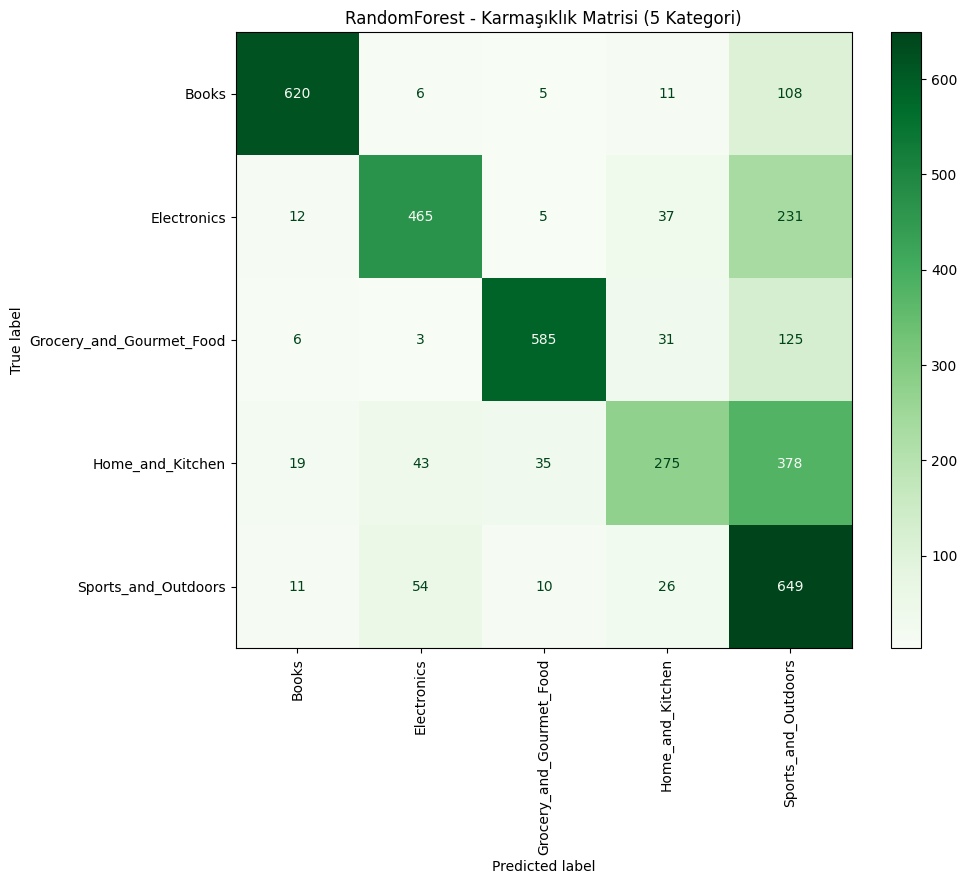

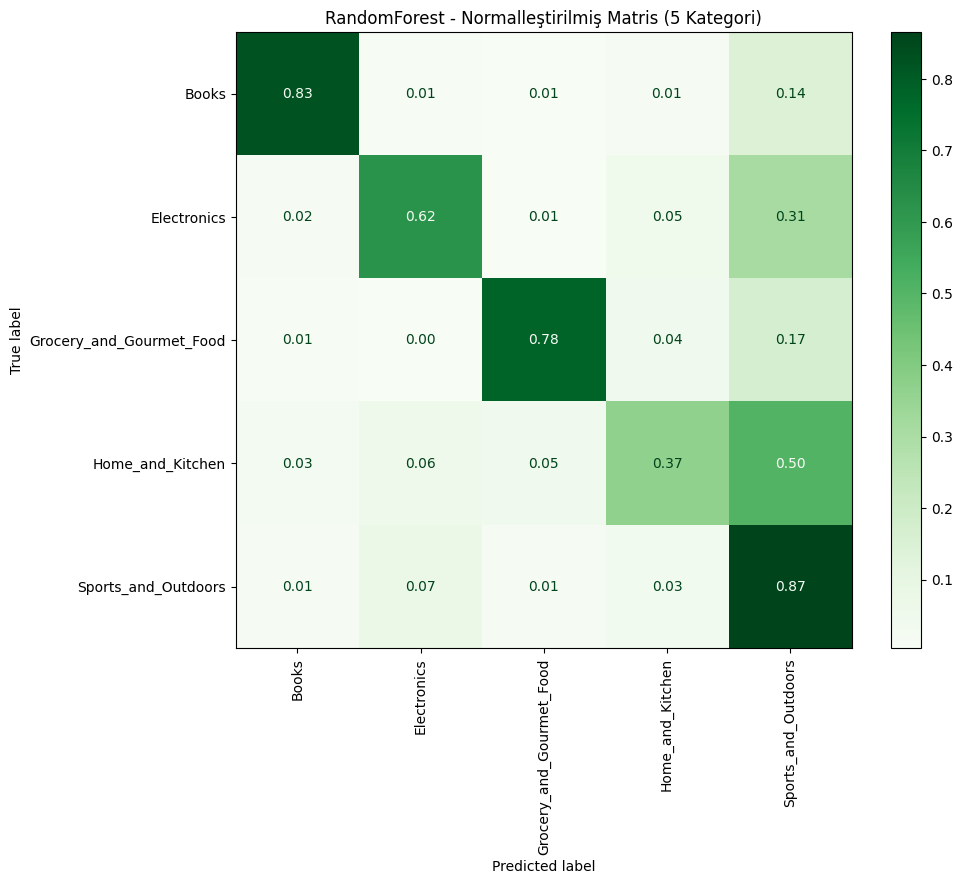

In [4]:
print("\n" + "="*60)
print("--- RandomForestClassifier (3 Kategori) Başladı ---")
print("="*60)


# 1.1 Veri Hazırlığı: Birbirinden çok farklı 3 kategoriyi seçme
stage1_categories = ["Books", "Electronics", "Grocery_and_Gourmet_Food"]
df_stage1_rf = df[df['category'].isin(stage1_categories)].copy()

print(f"\nAşama 1 için seçilen kategoriler: {stage1_categories}")
print(f"Kullanılacak veri boyutu: {len(df_stage1_rf)} satır")

# 1.2 Ön işleme fonksiyonunu uygulama
df_stage1_rf['processed_text'] = df_stage1_rf['text_input'].apply(preprocess_text)

# 1.3 Veriyi Eğitim ve Test Setlerine Ayırma
X_rf_3 = df_stage1_rf['processed_text']
y_rf_3 = df_stage1_rf['category']
X_train_rf_3, X_test_rf_3, y_train_rf_3, y_test_rf_3 = train_test_split(
    X_rf_3, y_rf_3, test_size=0.25, random_state=42, stratify=y_rf_3
)

# 1.4 Model Pipeline'ı Oluşturma ve Eğitme
pipeline_rf = make_pipeline(
    TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2)),
    RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1) # n_jobs=-1 işlemciyi tam kullanır
)

print("\nRandomForest modeli 3 kategori ile eğitiliyor...")
pipeline_rf.fit(X_train_rf_3, y_train_rf_3)
print("Model eğitimi tamamlandı.")

# 1.5 Değerlendirme
y_pred_rf_3 = pipeline_rf.predict(X_test_rf_3)
print("\n--- Değerlendirme Sonuçları (3 Kategori) ---")
print(classification_report(y_test_rf_3, y_pred_rf_3))

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(pipeline_rf, X_test_rf_3, y_test_rf_3, ax=ax, cmap='Greens')
plt.title('RandomForest - Karmaşıklık Matrisi (3 Kategori)')
plt.show()

# RandomForest - 3 Kategori - Normalize Matris
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_estimator(
    pipeline_rf, 
    X_test_rf_3, 
    y_test_rf_3, 
    ax=ax, 
    cmap='Greens',
    normalize='true',
    values_format='.2f'
)
plt.title('RandomForest - Normalleştirilmiş Matris (3 Kategori)')
plt.show()
####################################################################################
print("\n" + "="*60)
print("--- RandomForestClassifier (5 Kategori) Başladı ---")
print("="*60)


# 2.1 Veri Hazırlığı: 5 kategorinin tamamını kullanma
df_stage2_rf = df.copy()
df_stage2_rf['processed_text'] = df_stage2_rf['text_input'].apply(preprocess_text)

print(f"\nAşama 2 için kullanılan kategoriler: {df_stage2_rf['category'].unique().tolist()}")
print(f"Kullanılacak veri boyutu: {len(df_stage2_rf)} satır")

# 2.2 Veriyi Eğitim ve Test Setlerine Ayırma
X_rf_5 = df_stage2_rf['processed_text']
y_rf_5 = df_stage2_rf['category']
X_train_rf_5, X_test_rf_5, y_train_rf_5, y_test_rf_5 = train_test_split(
    X_rf_5, y_rf_5, test_size=0.25, random_state=42, stratify=y_rf_5
)

# 2.3 Model Eğitimi (Aynı pipeline'ı yeni veriyle eğiteceğiz)
print("\nRandomForest modeli 5 kategori ile yeniden eğitiliyor...")
pipeline_rf.fit(X_train_rf_5, y_train_rf_5)
print("Model eğitimi tamamlandı.")

# 2.4 Değerlendirme
y_pred_rf_5 = pipeline_rf.predict(X_test_rf_5)
print("\n--- Değerlendirme Sonuçları (5 Kategori) ---")
print(classification_report(y_test_rf_5, y_pred_rf_5))

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(pipeline_rf, X_test_rf_5, y_test_rf_5, ax=ax, cmap='Greens', xticks_rotation='vertical')
plt.title('RandomForest - Karmaşıklık Matrisi (5 Kategori)')
plt.show()
# RandomForest - 5 Kategori - Normalize Matris
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    pipeline_rf, 
    X_test_rf_5, 
    y_test_rf_5, 
    ax=ax, 
    cmap='Greens', 
    xticks_rotation='vertical',
    normalize='true',
    values_format='.2f'
)
plt.title('RandomForest - Normalleştirilmiş Matris (5 Kategori)')
plt.show()

> ***3.3 – XGBoostClassifier ile Model Eğitimi --- Ek olarak yapılmıştır.***


--- XGBoostClassifier (3 Kategori) Başladı ---

Aşama 1 için seçilen kategoriler: ['Books', 'Electronics', 'Grocery_and_Gourmet_Food']
Kullanılacak veri boyutu: 9000 satır

XGBoost modeli 3 kategori ile eğitiliyor...
Model eğitimi tamamlandı.

--- Değerlendirme Sonuçları (3 Kategori) ---
                          precision    recall  f1-score   support

                   Books       0.95      0.90      0.92       750
             Electronics       0.86      0.93      0.89       750
Grocery_and_Gourmet_Food       0.94      0.92      0.93       750

                accuracy                           0.92      2250
               macro avg       0.92      0.92      0.92      2250
            weighted avg       0.92      0.92      0.92      2250



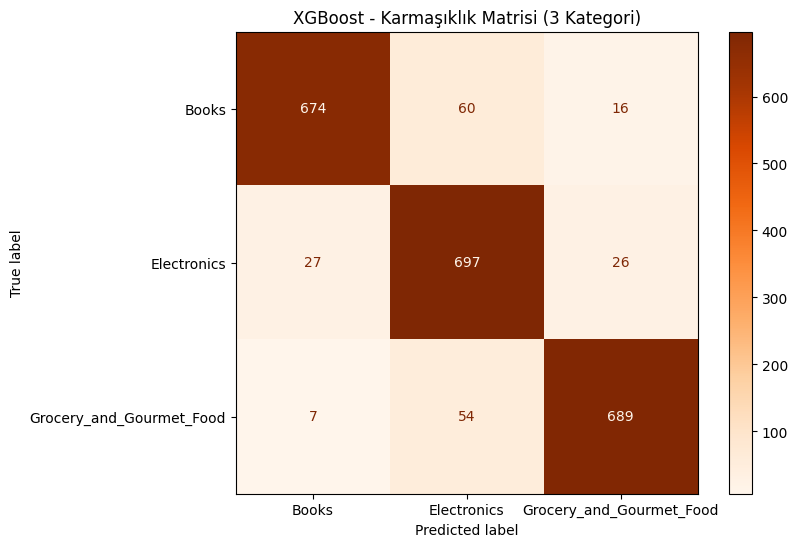

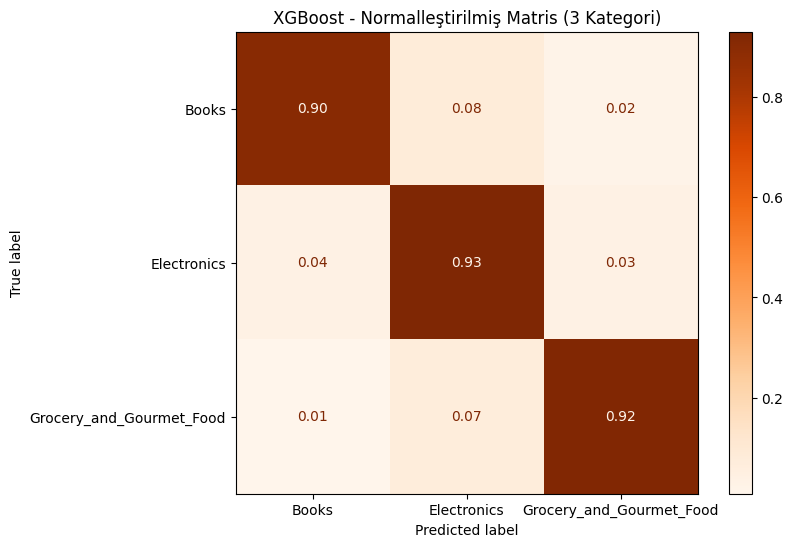


--- XGBoostClassifier (5 Kategori) Başladı ---

Aşama 2 için kullanılan kategoriler: ['Home_and_Kitchen', 'Grocery_and_Gourmet_Food', 'Sports_and_Outdoors', 'Books', 'Electronics']
Kullanılacak veri boyutu: 15000 satır

XGBoost modeli 5 kategori ile yeniden eğitiliyor...
Model eğitimi tamamlandı.

--- Değerlendirme Sonuçları (5 Kategori) ---
                          precision    recall  f1-score   support

                   Books       0.91      0.88      0.90       750
             Electronics       0.79      0.76      0.77       750
Grocery_and_Gourmet_Food       0.90      0.85      0.87       750
        Home_and_Kitchen       0.64      0.72      0.68       750
     Sports_and_Outdoors       0.69      0.68      0.69       750

                accuracy                           0.78      3750
               macro avg       0.79      0.78      0.78      3750
            weighted avg       0.79      0.78      0.78      3750



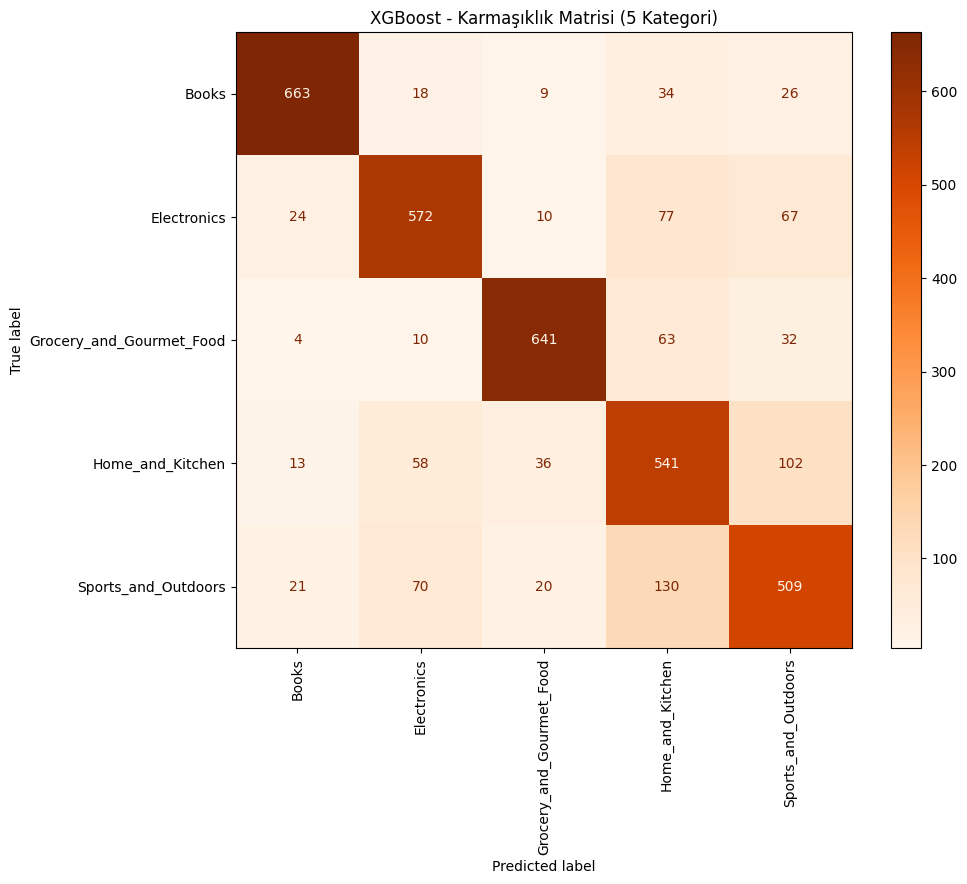

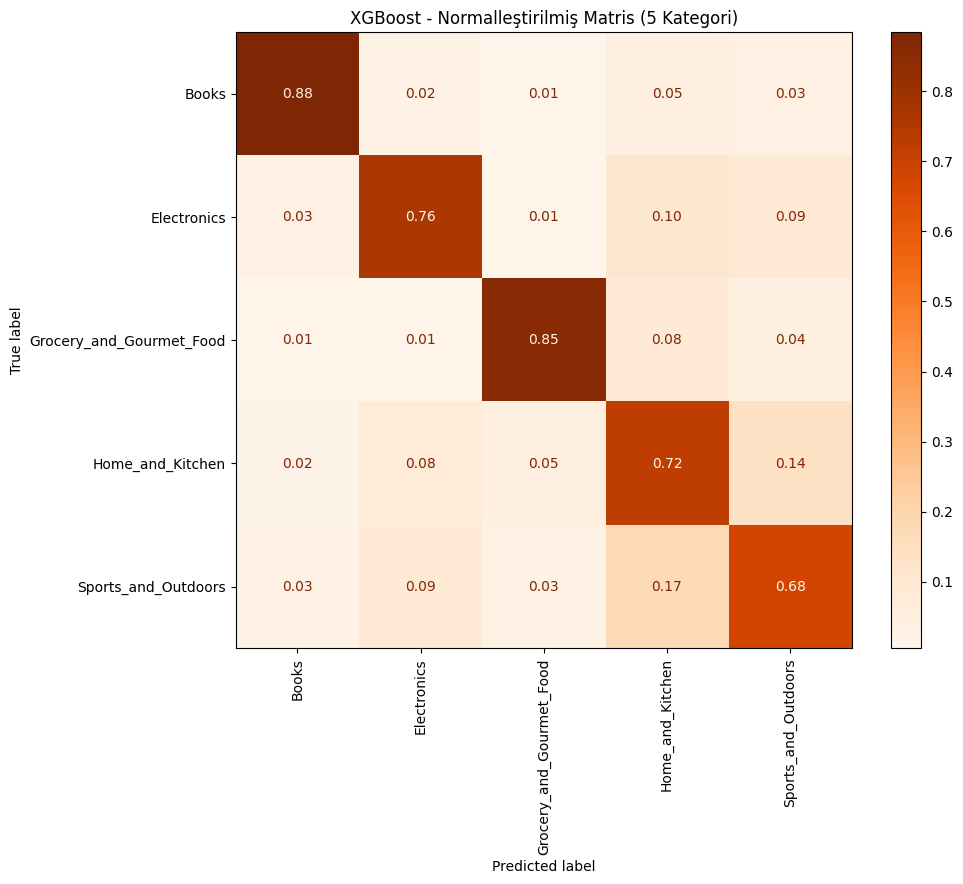

In [5]:
# Gerekli kütüphaneler
!pip install xgboost -q
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

print("\n" + "="*60)
print("--- XGBoostClassifier (3 Kategori) Başladı ---")
print("="*60)

# 1.1 Veri Hazırlığı
df_stage1_xgb = df[df['category'].isin(stage1_categories)].copy()
df_stage1_xgb['processed_text'] = df_stage1_xgb['text_input'].apply(preprocess_text)

print(f"\nAşama 1 için seçilen kategoriler: {stage1_categories}")
print(f"Kullanılacak veri boyutu: {len(df_stage1_xgb)} satır")

# 1.2 Veriyi Bölme ve Etiketleri Kodlama
X_xgb_3 = df_stage1_xgb['processed_text']
y_xgb_3 = df_stage1_xgb['category']
X_train_xgb_3, X_test_xgb_3, y_train_xgb_3, y_test_xgb_3 = train_test_split(
    X_xgb_3, y_xgb_3, test_size=0.25, random_state=42, stratify=y_xgb_3
)

# LabelEncoder'ı 3 kategori için eğit
le_3 = LabelEncoder()
y_train_encoded_3 = le_3.fit_transform(y_train_xgb_3)
y_test_encoded_3 = le_3.transform(y_test_xgb_3)

# 1.3 Pipeline Oluşturma ve Eğitme
pipeline_xgb = make_pipeline(
    TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2)),
    XGBClassifier(n_estimators=100, max_depth=6, use_label_encoder=False, eval_metric='mlogloss', random_state=42)
)

print("\nXGBoost modeli 3 kategori ile eğitiliyor...")
pipeline_xgb.fit(X_train_xgb_3, y_train_encoded_3)
print("Model eğitimi tamamlandı.")

# 1.4 Değerlendirme
y_pred_encoded_3 = pipeline_xgb.predict(X_test_xgb_3)
y_pred_xgb_3 = le_3.inverse_transform(y_pred_encoded_3) # Tahminleri geri metin etiketlerine çevir

print("\n--- Değerlendirme Sonuçları (3 Kategori) ---")
print(classification_report(y_test_xgb_3, y_pred_xgb_3))

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test_xgb_3, y_pred_xgb_3, ax=ax, cmap='Oranges')
plt.title('XGBoost - Karmaşıklık Matrisi (3 Kategori)')
plt.show()

# XGBoost - 3 Kategori - Normalize Matris
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test_xgb_3, 
    y_pred_xgb_3, 
    ax=ax, 
    cmap='Oranges',
    normalize='true',
    values_format='.2f'
)
plt.title('XGBoost - Normalleştirilmiş Matris (3 Kategori)')
plt.show()
####################################################################

print("\n" + "="*60)
print("--- XGBoostClassifier (5 Kategori) Başladı ---")
print("="*60)

# 2.1 Veri Hazırlığı
df_stage2_xgb = df.copy()
df_stage2_xgb['processed_text'] = df_stage2_xgb['text_input'].apply(preprocess_text)

print(f"\nAşama 2 için kullanılan kategoriler: {df_stage2_xgb['category'].unique().tolist()}")
print(f"Kullanılacak veri boyutu: {len(df_stage2_xgb)} satır")

# 2.2 Veriyi Bölme ve Etiketleri Kodlama
X_xgb_5 = df_stage2_xgb['processed_text']
y_xgb_5 = df_stage2_xgb['category']
X_train_xgb_5, X_test_xgb_5, y_train_xgb_5, y_test_xgb_5 = train_test_split(
    X_xgb_5, y_xgb_5, test_size=0.25, random_state=42, stratify=y_xgb_5
)

# LabelEncoder'ı 5 kategori için eğit
le_5 = LabelEncoder()
y_train_encoded_5 = le_5.fit_transform(y_train_xgb_5)
y_test_encoded_5 = le_5.transform(y_test_xgb_5)

# 2.3 Model Eğitimi (Aynı pipeline'ı yeni veriyle eğiteceğiz)
print("\nXGBoost modeli 5 kategori ile yeniden eğitiliyor...")
pipeline_xgb.fit(X_train_xgb_5, y_train_encoded_5)
print("Model eğitimi tamamlandı.")

# 2.4 Değerlendirme
y_pred_encoded_5 = pipeline_xgb.predict(X_test_xgb_5)
y_pred_xgb_5 = le_5.inverse_transform(y_pred_encoded_5) # Tahminleri geri metin etiketlerine çevir

print("\n--- Değerlendirme Sonuçları (5 Kategori) ---")
print(classification_report(y_test_xgb_5, y_pred_xgb_5))

fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(y_test_xgb_5, y_pred_xgb_5, ax=ax, cmap='Oranges', xticks_rotation='vertical')
plt.title('XGBoost - Karmaşıklık Matrisi (5 Kategori)')
plt.show()
# XGBoost - 5 Kategori - Normalize Matris
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test_xgb_5, 
    y_pred_xgb_5, 
    ax=ax, 
    cmap='Oranges', 
    xticks_rotation='vertical',
    normalize='true',
    values_format='.2f'
)
plt.title('XGBoost - Normalleştirilmiş Matris (5 Kategori)')
plt.show()

***Opsiyonel Aşama: TF-IDF + KMeans Kümeleme***


--- TF-IDF + KMeans Kümeleme Başladı ---
Kümeleme tamamlandı. Her örnek bir kümeye atanmıştır.

Küme Dağılımı:
cluster
0    9805
2    2156
3    1939
4     894
1     206
Name: count, dtype: int64

PCA ile 2 boyutlu görselleştirme hazırlanıyor...


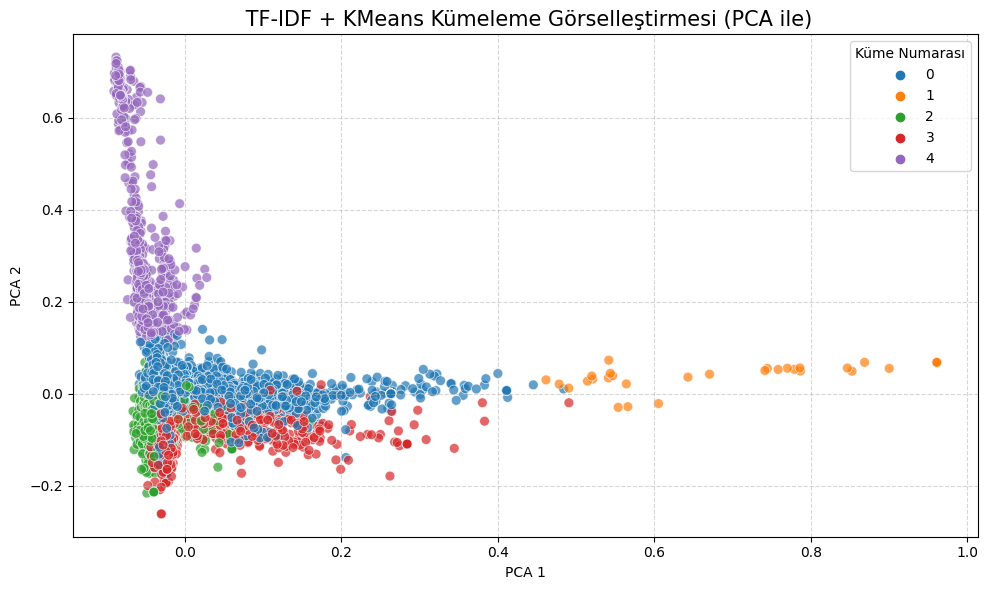


Her küme için en belirgin kelimeler:

Küme 0:
En sık terimler: good, love, nice, like, stars, just, use, perfect, easy, really

Küme 1:
En sık terimler: good product, product, product good, good, work, stars good, used, recommend, health, adjust

Küme 2:
En sık terimler: book, read, br, story, books, reading, recipes, great, characters, good

Küme 3:
En sık terimler: great, works, works great, great product, product, quality, love, value, price, great value

Küme 4:
En sık terimler: reviews, info, update, useful, new info, info useful, update reviews, hesitate update, reviews new, hesitate

---  TAMAMLANDI ---
------------------------------------------------------------


In [6]:
print("\n--- TF-IDF + KMeans Kümeleme Başladı ---")

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. TF-IDF vektörleştirme (önceki aşamadaki işlemle aynı, ancak bu sefer direkt numpy matris olarak kullanacağız)
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(df_stage2['processed_text'])

# 2. KMeans modelini oluştur ve eğit (5 küme seçildi, çünkü 5 kategori vardı)
kmeans = KMeans(n_clusters=5, init='k-means++', random_state=42)
df_stage2['cluster'] = kmeans.fit_predict(X_tfidf)

print("Kümeleme tamamlandı. Her örnek bir kümeye atanmıştır.")

# 3. Her kümede örnek sayısını görüntüle
print("\nKüme Dağılımı:")
print(df_stage2['cluster'].value_counts())

# 4. PCA ile 2 boyuta indirip kümeleri görselleştir
print("\nPCA ile 2 boyutlu görselleştirme hazırlanıyor...")
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_stage2['cluster'], palette='tab10', s=50, alpha=0.7)
plt.title(' TF-IDF + KMeans Kümeleme Görselleştirmesi (PCA ile)', fontsize=15)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Küme Numarası')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# 5. Kümelerdeki en sık geçen kelimeleri incelemek için centroid'leri yorumlama
print("\nHer küme için en belirgin kelimeler:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names_out()

for i in range(5):
    print(f"\nKüme {i}:")
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("En sık terimler:", ", ".join(top_words))

print("\n---  TAMAMLANDI ---")
print("-" * 60)


# ***Başlıktan Açıklama Üretimi (GenAI)***

> ***flan-t5-small***

In [7]:
# !pip install transformers datasets torch accelerate sentencepiece

import torch
import json
import random
from datasets import load_dataset
from transformers import pipeline, T5Tokenizer


print("Gerekli kütüphaneler ve flan-t5-small modeli yükleniyor...")
device = 0 if torch.cuda.is_available() else -1


model_name = "google/flan-t5-small"
try:
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    generator = pipeline(
        "text2text-generation",
        model=model_name,
        tokenizer=tokenizer,
        device=device
    )
    print(f"'{model_name}' başarıyla yüklendi.")
except Exception as e:
    print(f"Model yüklenirken bir hata oluştu: {e}")
    exit()

# Amazon Beauty veri seti yükleniyor
try:
    dataset = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        "raw_meta_All_Beauty",
        split="full",
        trust_remote_code=True
    )
except Exception as e:
    print(f"Veri seti yüklenemedi: {e}")
    exit()


#  Rastgele 10 Ürün Seçimi

print("\nVeri filtreleniyor ve uygun ürünler aranıyor...")
eligible_products = []
for item in dataset:
    if item.get("title") and item.get("features") and len(item["features"]) > 0:
        eligible_products.append({
            "title": item["title"],
            "features": item.get("features", []),
            "details": item.get("details", '{}'),
        })

print(f"Kriterlere uyan toplam {len(eligible_products)} ürün bulundu.")

num_samples = 10
if len(eligible_products) >= num_samples:
    random_products = random.sample(eligible_products, num_samples)
    print(f"İçlerinden rastgele {num_samples} ürün seçildi.")
else:
    random_products = eligible_products


# Girdiyi Temizleme

def format_features(features):
    if not features or not isinstance(features, list): return None
    return "\n- ".join(features)

def format_details(details_str):
    try:
        details_dict = json.loads(details_str)
        if not details_dict or not isinstance(details_dict, dict): return None
        unwanted_keys = ['UPC', 'ASIN', 'Item model number', 'Package Dimensions', 'Is Discontinued By Manufacturer']
        filtered_details = {k: v for k, v in details_dict.items() if k not in unwanted_keys}
        if not filtered_details: return None
        return "\n".join([f"{k}: {v}" for k, v in filtered_details.items()])
    except (json.JSONDecodeError, TypeError):
        return None

# (En İyi Sonuç İçin Few-Shot Prompt)

def make_advanced_prompt(prod):
    title = prod['title']
    features_text = format_features(prod.get('features'))
    details_text = format_details(prod.get('details'))
    
    prompt = f"""
You are an expert e-commerce copywriter. Your task is to write a short, persuasive, and professional product description of 3-4 sentences based on the provided data.

### EXAMPLE ###
CONTEXT:
Product Title: VIROCHEMISTRY Pheromones For Women - Ultra Strength Organic Fragrance
Features:
- Scientifically Formulated Human Pheromone Blend
- Irresistible Smelling Perfume
- Patented Blend of Human Pheromones
- Long-lasting: Works for over 35 hours
Specifications:
Brand: VIROCHEMISTRY
Item Form: Liquid

DESCRIPTION:
Unlock your inner confidence with the VIROCHEMISTRY Pheromone Perfume for Women. This scientifically formulated fragrance features a patented blend of human pheromones designed to create an irresistible and alluring scent. Its ultra strength, long-lasting formula works for over 35 hours, ensuring you feel empowered and captivating all day long. Experience the perfect fusion of science and elegance in a single bottle.

### TASK ###
CONTEXT:
Product Title: {title}
"""
    if features_text:
        prompt += f"\nFeatures:\n- {features_text}\n"
    if details_text:
        prompt += f"\nSpecifications:\n{details_text}\n"
    prompt += "\nDESCRIPTION:\n"
    return prompt


print("\nOptimize edilmiş model ile açıklamalar oluşturuluyor...\n")
for i, prod in enumerate(random_products):
    prompt = make_advanced_prompt(prod)
    
    generation_params = {
        "max_length": 256,
        "num_beams": 4,
        "temperature": 0.8,
        "no_repeat_ngram_size": 2,
        "early_stopping": True
    }
    
    #  truncation=True ile prompt'un modele sığmasını sağlıyoruz.
    result = generator(prompt, truncation=True, **generation_params)

    print(f"{'='*50}\nPRODUCT {i+1}: {prod['title']}\n{'-'*50}")
    print("\nGENERATED DESCRIPTION:")
    print(result[0]['generated_text'])
    print(f"\n{'='*50}\n")

2025-06-30 14:59:21.389253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751295561.566371      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751295561.615020      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Gerekli kütüphaneler ve flan-t5-small modeli yükleniyor...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


'google/flan-t5-small' başarıyla yüklendi.


meta_All_Beauty.jsonl:   0%|          | 0.00/213M [00:00<?, ?B/s]

Generating full split:   0%|          | 0/112590 [00:00<?, ? examples/s]


Veri filtreleniyor ve uygun ürünler aranıyor...
Kriterlere uyan toplam 17374 ürün bulundu.
İçlerinden rastgele 10 ürün seçildi.

Optimize edilmiş model ile açıklamalar oluşturuluyor...

PRODUCT 1: Beard & Hair Roller Black w/Green 540 Stainless Steel Microneedling Derma Roller MOOKARDILANE Face Home Use
--------------------------------------------------

GENERATED DESCRIPTION:
540 Stainless Steel Microneedling Derma Roller MOOKARDILANE Face Home Use


PRODUCT 2: Ultra Rich Hair Balm - For Coarse, Curly and Dry Hair - Conditions and Shines with No Silicone Or Synthetic Ingredients - Leaves No Sticky Build Up In Hair - 1.5 Oz
--------------------------------------------------

GENERATED DESCRIPTION:
Coconut Liquid is a great product for hair.


PRODUCT 3: Dove Nutritive Solutions Strengthening Conditioner for Damaged Hair Intensive Repair Deep Conditioner Formula with Keratin Actives 12 oz
--------------------------------------------------

GENERATED DESCRIPTION:
Dove Nutritive Solution

> ***flan-t5-base***

In [8]:
# !pip install transformers datasets torch accelerate sentencepiece

import torch
import json
import random
from datasets import load_dataset
from transformers import pipeline, T5Tokenizer


print("Gerekli kütüphaneler ve flan-t5-base modeli yükleniyor...")
device = 0 if torch.cuda.is_available() else -1


model_name = "google/flan-t5-base"
try:
    tokenizer = T5Tokenizer.from_pretrained(model_name)
    generator = pipeline(
        "text2text-generation",
        model=model_name,
        tokenizer=tokenizer,
        device=device
    )
    print(f"'{model_name}' başarıyla yüklendi.")
except Exception as e:
    print(f"Model yüklenirken bir hata oluştu: {e}")
    exit()

# Amazon Beauty veri seti yükleniyor
try:
    dataset = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        "raw_meta_All_Beauty",
        split="full",
        trust_remote_code=True
    )
except Exception as e:
    print(f"Veri seti yüklenemedi: {e}")
    exit()


#  Rastgele 10 Ürün Seçimi

print("\nVeri filtreleniyor ve uygun ürünler aranıyor...")
eligible_products = []
for item in dataset:
    if item.get("title") and item.get("features") and len(item["features"]) > 0:
        eligible_products.append({
            "title": item["title"],
            "features": item.get("features", []),
            "details": item.get("details", '{}'),
        })

print(f"Kriterlere uyan toplam {len(eligible_products)} ürün bulundu.")

num_samples = 10
if len(eligible_products) >= num_samples:
    random_products = random.sample(eligible_products, num_samples)
    print(f"İçlerinden rastgele {num_samples} ürün seçildi.")
else:
    random_products = eligible_products


# Girdiyi Temizleme

def format_features(features):
    if not features or not isinstance(features, list): return None
    return "\n- ".join(features)

def format_details(details_str):
    try:
        details_dict = json.loads(details_str)
        if not details_dict or not isinstance(details_dict, dict): return None
        unwanted_keys = ['UPC', 'ASIN', 'Item model number', 'Package Dimensions', 'Is Discontinued By Manufacturer']
        filtered_details = {k: v for k, v in details_dict.items() if k not in unwanted_keys}
        if not filtered_details: return None
        return "\n".join([f"{k}: {v}" for k, v in filtered_details.items()])
    except (json.JSONDecodeError, TypeError):
        return None

# (En İyi Sonuç İçin Few-Shot Prompt)

def make_advanced_prompt(prod):
    title = prod['title']
    features_text = format_features(prod.get('features'))
    details_text = format_details(prod.get('details'))
    
    prompt = f"""
You are an expert e-commerce copywriter. Your task is to write a short, persuasive, and professional product description of 3-4 sentences based on the provided data.

### EXAMPLE ###
CONTEXT:
Product Title: VIROCHEMISTRY Pheromones For Women - Ultra Strength Organic Fragrance
Features:
- Scientifically Formulated Human Pheromone Blend
- Irresistible Smelling Perfume
- Patented Blend of Human Pheromones
- Long-lasting: Works for over 35 hours
Specifications:
Brand: VIROCHEMISTRY
Item Form: Liquid

DESCRIPTION:
Unlock your inner confidence with the VIROCHEMISTRY Pheromone Perfume for Women. This scientifically formulated fragrance features a patented blend of human pheromones designed to create an irresistible and alluring scent. Its ultra strength, long-lasting formula works for over 35 hours, ensuring you feel empowered and captivating all day long. Experience the perfect fusion of science and elegance in a single bottle.

### TASK ###
CONTEXT:
Product Title: {title}
"""
    if features_text:
        prompt += f"\nFeatures:\n- {features_text}\n"
    if details_text:
        prompt += f"\nSpecifications:\n{details_text}\n"
    prompt += "\nDESCRIPTION:\n"
    return prompt


print("\nOptimize edilmiş model ile açıklamalar oluşturuluyor...\n")
for i, prod in enumerate(random_products):
    prompt = make_advanced_prompt(prod)
    
    generation_params = {
        "max_length": 256,
        "num_beams": 4,
        "temperature": 0.8,
        "no_repeat_ngram_size": 2,
        "early_stopping": True
    }
    
    #  truncation=True ile prompt'un modele sığmasını sağlıyoruz.
    result = generator(prompt, truncation=True, **generation_params)

    print(f"{'='*50}\nPRODUCT {i+1}: {prod['title']}\n{'-'*50}")
    print("\nGENERATED DESCRIPTION:")
    print(result[0]['generated_text'])
    print(f"\n{'='*50}\n")

Gerekli kütüphaneler ve flan-t5-base modeli yükleniyor...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0


'google/flan-t5-base' başarıyla yüklendi.

Veri filtreleniyor ve uygun ürünler aranıyor...
Kriterlere uyan toplam 17374 ürün bulundu.
İçlerinden rastgele 10 ürün seçildi.

Optimize edilmiş model ile açıklamalar oluşturuluyor...

PRODUCT 1: Supernail Silky Linen Wrap, 72 Inch
--------------------------------------------------

GENERATED DESCRIPTION:
Supernail Silky Linen Wrap, 72 Inch Features: - Smooth and strong protection. Silk and linen blend. Easy to apply wrap.


PRODUCT 2: Cardani Indelible Eyebrow Makeup Stick - Eyebrow Pencil Cosmetics Eyebrow Pencil - Brunette
--------------------------------------------------

GENERATED DESCRIPTION:
Cardani Indelible Eyebrow Makeup Stick is a long lasting makeup stick with multiple shades. It features an eyebrow brush at the tip for added realism when applying.


PRODUCT 3: Earth Therapeutics Mind/Body Therapy Sleep Mask, Cotton, Silk, 1 mask (Pack of 2)
--------------------------------------------------

GENERATED DESCRIPTION:
Earth Therapeu